In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.11.0


# **Getting the Data and Setting up TensorBoard**

In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-10-12 01:28:35--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.73.9.93, 54.165.51.142, 54.164.206.44, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.73.9.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.46MB/s    in 0.7s    

2018-10-12 01:28:36 (7.46 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log5/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [5]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://18de6201.ngrok.io


In [0]:
from tensorflow.python.keras.callbacks import TensorBoard


In [7]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.


In [8]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [9]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


# Embedding Matrix using Word2Vec Model

In [10]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 21063 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

Importing the embedding matrix file from my google drive

In [0]:
import numpy as np
embedding_matrix = np.loadtxt("drive/Colab Notebooks/embedding_matrix_google_word2vec.out")

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=500)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=500)

# **CNN-LSTM Sequential Model**

In [14]:
import time

# input shape is the vocabulary count used for the movie reviews (10,000 words)
NUM_WORDS = 10000
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


model = keras.Sequential()

# embedding layer
model.add(keras.layers.Embedding(vocabulary_size,EMBEDDING_DIM, weights=[embedding_matrix],trainable=True))

# convLayer1
model.add(keras.layers.Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))

# convLayer2
model.add(keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=4))

# convLayer3
model.add(keras.layers.Conv1D(filters=128, kernel_size=6, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=8))

# lstm
model.add(keras.layers.LSTM(64, dropout = 0.2))

# dense
model.add(keras.layers.Dense(32))

# dense
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

tbCallBack = keras.callbacks.TensorBoard(log_dir="./log5/{}".format(time.time()))

model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          38432     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
__________

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=3,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[tbCallBack])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/3
15000/15000 [==============================] - 167s 11ms/step - loss: 0.4582 - acc: 0.7579 - val_loss: 0.4943 - val_acc: 0.8364
Epoch 2/3
15000/15000 [==============================] - 166s 11ms/step - loss: 0.2537 - acc: 0.9030 - val_loss: 0.2434 - val_acc: 0.9035
Epoch 3/3
15000/15000 [==============================] - 165s 11ms/step - loss: 0.1903 - acc: 0.9301 - val_loss: 0.2625 - val_acc: 0.9020


In [17]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 65s 3ms/step
[0.26901319749593733, 0.90004]


# **Accuracy : 90%**

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

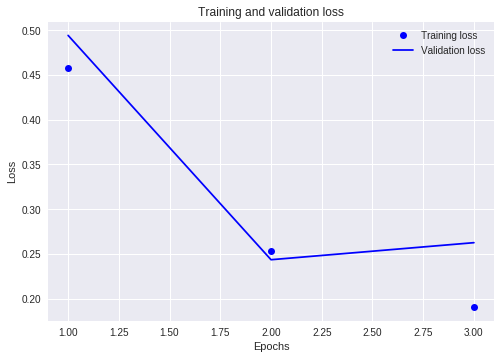

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

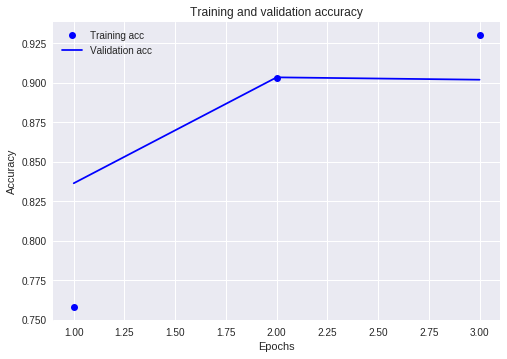

In [20]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()